### Processd BoolODE data for this experiment can be downloaded from the following link
Data download: https://huggingface.co/datasets/lazaratan/sf2m-grn-boolode-data/blob/main/sf2m-grn-data.zip

In [1]:
import pandas as pd
import numpy as np
import scprep
from sklearn.metrics import roc_auc_score, average_precision_score
import os
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from copy import deepcopy

In [2]:
def plot(simdir):
    
    simulation_dir = os.path.join(simdir, "simulations")
    n_cells = len([s for s in os.listdir(simulation_dir) if s.endswith(".csv")])
    dfs = [0] * n_cells
    for f in os.listdir(simulation_dir):
        if not f.endswith("csv"):
            continue
        i = int(f.split(".")[0][1:])
        dfs[i] = pd.read_csv(os.path.join(simulation_dir, f), index_col=0)
    ref_net = pd.read_csv(os.path.join(simdir, "refNetwork.csv"))
    n_genes = dfs[0].shape[0]
    genes = [f"g{i+1}" for i in range(n_genes)]

    data = []
    for df in dfs:
        data.append(df.values)
    data = np.array(data)

    #print(data.shape)
    data = np.swapaxes(data, 1, 2)
    
    # cells x time x genes
    data = data[:, ::9, :]
    data = data[:, 1:, :]


    A = np.zeros((n_genes, n_genes))
    for i, row in ref_net.iterrows():
        gene1 = int(row["Gene1"][1:]) # - 1 if gene names don't start at zero
        gene2 = int(row["Gene2"][1:]) # - 1 if gene names don't start at zero
        rel = 1 if row["Type"] == "+" else -1
        A[gene1, gene2] = rel

    return data, np.abs(A)

In [3]:
datas_train, datas_val = [], []
graphs_train, graphs_val = [], []
actions_train, actions_val = [], []
train_val_split = [0.8, 0.2]
for path in os.listdir("Synthetic-I"):
    p = os.path.join("Synthetic-I", path)
    #if 'I-3' not in p:
    #    continue
    if 'BF' in p or 'I-2' in p or 'I-3' in p or 'large' in p or 'gnull' not in p:
        continue
    #if 'BF-I-large' not in p:
    #    continue
    else:
        print(p)
        data, graph = plot(p)
        train_len = int(data.shape[0]*train_val_split[0])
        val_len = int(data.shape[0]*train_val_split[1])
        print(data.shape, train_len, val_len)
        action = np.ones((data.shape[0], data.shape[-1]))
        if 'null' in p:
            print("No intervention")
            actions_train.append(action[:train_len])
            actions_val.append(action[train_len:])
        else:
            if 'I-3' not in p:
                a = int(list(filter(str.isdigit, p))[0])
            else:
                a = int(list(filter(str.isdigit, p))[1])
            print("Knock-out intervention on g%d" % a)
            action[:, a] = 0
            actions_train.append(action[:train_len])
            actions_val.append(action[train_len:])
        graphs_train.append(graph)
        graphs_val.append(graph)
        datas_train.append(data[:train_len])
        datas_val.append(data[train_len:])
print("Example boolODE data:", datas_train[0].shape, datas_val[0].shape)
true_graph = graphs_val[0]

Synthetic-I/dyn-TF-I-gnull


(800, 66, 9) 640 160
No intervention
Example boolODE data: (640, 66, 9) (160, 66, 9)


<class 'networkx.classes.digraph.DiGraph'>


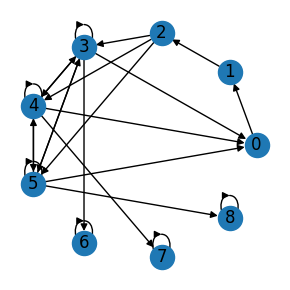

In [4]:
# plot GRN (causal graph)

import networkx as nx
fig, ax = plt.subplots(1,1, figsize=(3,3))
G = nx.from_numpy_array(graph, create_using=nx.DiGraph)
print(type(G))
nx.draw(G, ax=ax, pos=nx.circular_layout(G), arrows=True, with_labels=True)
plt.tight_layout()

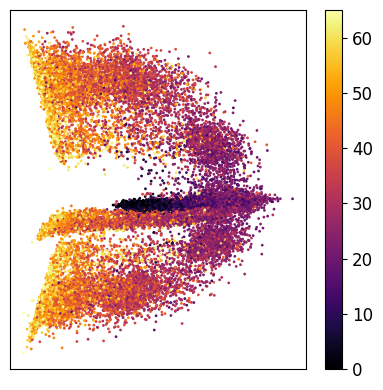

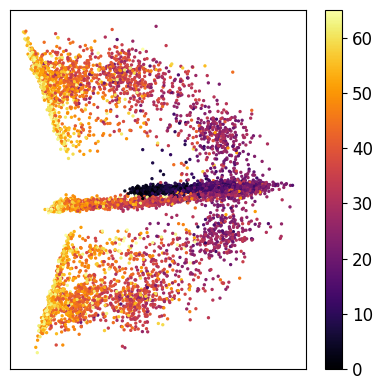

In [5]:
from sklearn.decomposition import PCA
fig, ax = plt.subplots(1,1, figsize=(4,4))
pca = PCA(n_components=2)
cells_null = datas_train[0].reshape(-1, datas_train[0].shape[-1])
pca_embed = pca.fit_transform(cells_null)
for data, graph in zip(datas_train, graphs_train):
    cells = data.reshape(-1, data.shape[-1])
    pca_embed = pca.transform(cells)
    labels = np.repeat(np.arange(data.shape[1])[None,:], data.shape[0], axis=0).flatten()
    scprep.plot.scatter2d(pca_embed, c=labels, ax=ax, ticks=False, colorbar=True)
plt.tight_layout()

fig, ax = plt.subplots(1,1, figsize=(4,4))
pca = PCA(n_components=2)
cells_null = datas_val[0].reshape(-1, datas_val[0].shape[-1])
pca_embed = pca.fit_transform(cells_null)
for data, graph in zip(datas_val, graphs_val):
    cells = data.reshape(-1, data.shape[-1])
    pca_embed = pca.transform(cells)
    labels = np.repeat(np.arange(data.shape[1])[None,:], data.shape[0], axis=0).flatten()
    scprep.plot.scatter2d(pca_embed, c=labels, ax=ax, ticks=False, colorbar=True)
plt.tight_layout()

In [6]:
import math

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torch.nn.functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader

In [7]:
import sys
from pathlib import Path

# Go up from notebook dir to project root (i.e., where 'runner' is)
curr = Path.cwd()
while not (curr / 'runner').exists() and curr != curr.parent:
    curr = curr.parent

# Add the project root to sys.path
sys.path.append(str(curr))

from runner.src.models.components import distribution_distances as dd 

In [9]:
def plot_pca_manifold(data, preds, ax, a=None):
    cells = data.reshape(-1, data.shape[-1])
    pca = PCA(n_components=2)
    pca_embed = pca.fit_transform(cells)
    pca_xT = pca.transform(preds)
    cells_end_points = np.stack([preds], axis=1)
    pca_cell_end_points = np.stack([pca_xT], axis=1)
    pca_cell_end_points = pca_cell_end_points.reshape(-1, pca_cell_end_points.shape[-1])
    labels = np.repeat(np.arange(data.shape[1])[None,:], data.shape[0], axis=0).flatten()
    scprep.plot.scatter2d(pca_embed, c=labels, ax=ax, ticks=False, colorbar=True)
    if a is None:
        labels_end_points = np.repeat(np.arange(cells_end_points.shape[1])[None,:], cells_end_points.shape[0], axis=0).flatten()
        scprep.plot.scatter2d(pca_cell_end_points, c=labels_end_points, ax=ax, ticks=False, colorbar=True)
    else:
        a = a.detach().cpu().numpy()
        group = []
        group_dict = {'control': [], 'g3': [], 'g4': []}
        data_dict = {'control': [], 'g3': [], 'g4': []}
        for i in range(a.shape[0]):
            not_control = (a[i].sum() < len(a[i]))
            if not_control == False:
                group.append(50)
                group_dict['control'].append('cyan')
                data_dict['control'].append(pca_cell_end_points[i])
            else:
                a_label = np.where(a[i] == 0)[0]
                #group.append(int(a_label) + 1)
                group.append(int(a_label))
                group_dict['g'+str(int(a_label))].append('red' if int(a_label) == 3 else 'blue')
                data_dict['g'+str(int(a_label))].append(pca_cell_end_points[i])
        for k, v in group_dict.items():
            if len(v) > 0:
                #scprep.plot.scatter2d(pca_cell_end_points, c=v, label=k, ax=ax, ticks=False, colorbar=True)
                scprep.plot.scatter2d(np.array(data_dict[k]), c=v, label=k, ax=ax, ticks=False, colorbar=True)
    plt.tight_layout()
    return pca

In [10]:
from sklearn.metrics import average_precision_score, roc_auc_score

def structural_hamming_distance(W_true, W_est):
        """Computes the structural hamming distance."""
        pred = np.flatnonzero(W_est != 0)
        cond = np.flatnonzero(W_true)
        cond_reversed = np.flatnonzero(W_true.T)
        extra = np.setdiff1d(pred, cond, assume_unique=True)
        reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
        pred_lower = np.flatnonzero(np.tril(W_est + W_est.T))
        cond_lower = np.flatnonzero(np.tril(W_true + W_true.T))
        extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
        missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
        shd = len(extra_lower) + len(missing_lower) + len(reverse)
        return shd

def plot_graph_heatmap(graph, ax, auc=None):
    pcm = ax.matshow(graph, cmap="viridis")
    if auc is not None:
        #title = title + ''
        ax.set_title(r'Pred Graph: AUC = %0.3f' % auc)
    else:
        ax.set_title(r'True Graph')
    fig.colorbar(pcm, ax=ax)

In [11]:
def compute_metrics(true_graph, estimated_graph):
    ### AUCROC
    AUCROC = roc_auc_score(true_graph, estimated_graph)
    
    ### AP
    AP = average_precision_score(true_graph, estimated_graph)

    ### Add symmetry score --> predics undirected effects
    estimated_sym = (estimated_graph + np.transpose(estimated_graph)) / 2
    true_sym = (((true_graph + np.transpose(true_graph)) / 2) > 0) * 1

    ### AUCROC symmetric
    AUCROC_sym = roc_auc_score(true_sym, estimated_sym)

    ### AP symmetric
    AP_sym = average_precision_score(true_sym, estimated_sym)
    
    metrics = ['AUCROC', 'AP', 'AUCROC_sym', 'AP_sym']
    df_graph_metrics = pd.DataFrame(
        [AUCROC, AP, AUCROC_sym, AP_sym],
        index=metrics,
        )
    return df_graph_metrics

In [12]:
def plot_sc_trajectories(traj, sc_boolode, a, W2, pca_full, ax):
    n = 2000
    #cells = sc_boolode.reshape(-1, sc_boolode.shape[-1])
    #pca_embed = pca.fit_transform(cells)
    traj_pca = []
    for i in range(traj.shape[0]):
        traj_pca.append(torch.tensor(pca_full.transform(traj[i].cpu().detach().numpy())))
    traj_pca = torch.stack(traj_pca, dim=0)
    
    a = a.detach().cpu().numpy()
    group = []
    group_dict = {'control': [], 'g3': [], 'g4': []}
    data_dict_traj_0 = {'control': [], 'g3': [], 'g4': []}
    data_dict_traj_1 = {'control': [], 'g3': [], 'g4': []}
    for i in range(a.shape[0]):
            not_control = (a[i].sum() < len(a[i]))
            if not_control == False:
                group.append(50)
                group_dict['control'].append('cyan')
                data_dict_traj_0['control'].append(traj_pca[-1, i, 0])
                data_dict_traj_1['control'].append(traj_pca[-1, i, 1])
            else:
                a_label = np.where(a[i] == 0)[0]
                #group.append(int(a_label) + 1)
                group.append(int(a_label))
                group_dict['g'+str(int(a_label))].append('red' if int(a_label) == 3 else 'blue')
                data_dict_traj_0['g'+str(int(a_label))].append(traj_pca[-1, i, 0])
                data_dict_traj_1['g'+str(int(a_label))].append(traj_pca[-1, i, 1])

    #plt.figure(figsize=(6, 6))
    ax.scatter(traj_pca[0, :n, 0], traj_pca[0, :n, 1], s=10, alpha=0.8, c="black")
    ax.scatter(traj_pca[:, :n, 0], traj_pca[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    #ax.scatter(traj_pca[-1, :n, 0], traj_pca[-1, :n, 1], s=4, alpha=1, c="blue")
    for k, v in group_dict.items():
        if len(v) > 0:
            traj_pca_0, traj_pca_1 = data_dict_traj_0[k], data_dict_traj_1[k]
            #ax.scatter(traj_pca[-1, :n, 0], traj_pca[-1, :n, 1], s=4, alpha=1, c=v, label=k)
            ax.scatter(traj_pca_0, traj_pca_1, s=4, alpha=1, c=v, label=k)
    ax.legend(["Prior sample z(S)", "Flow", "z(0)"])
    ax.set_title(r'2-Wasserstein($x_T$,  $\hat{x_T}$) = %f' % W2)
    #ax.xticks([])
    #ax.yticks([])
    #ax.show()
    plt.tight_layout()

In [13]:
def get_datasets(seed):
    np.random.seed(seed)
    # shuffle train data cell pairs to emulate single-cell data
    datas_train_shuffled = []
    data_train_to_shuffle = datas_train
    for D in data_train_to_shuffle:
        D_shuffled = []
        for t in range(D.shape[1]):
            choices = np.random.choice(D[:, t, :].shape[0], size=D[:, t, :].shape[0])
            D_shuffled.append(torch.tensor(D[choices, t, :]).float())
        shuffled_data = torch.stack(D_shuffled, dim=1).cpu().detach().numpy()
        datas_train_shuffled.append(shuffled_data)

    # compile train data
    #train_datas = [torch.from_numpy(item).float() for item in datas_train]
    train_datas = [torch.from_numpy(item).float() for item in datas_train_shuffled]
    train_data = torch.cat(train_datas, dim=0)

    # shuffle val data cell pairs to emulate single-cell data
    datas_val_shuffled = []
    datas_val_to_shuffled = datas_val
    for D in datas_val_to_shuffled:
        D_shuffled = []
        for t in range(D.shape[1]):
            choices = np.random.choice(D[:, t, :].shape[0], size=D[:, t, :].shape[0])
            D_shuffled.append(torch.tensor(D[choices, t, :]).float())
        shuffled_data = torch.stack(D_shuffled, dim=1).cpu().detach().numpy()
        datas_val_shuffled.append(shuffled_data)

    # compile validation data
    #val_datas = [torch.from_numpy(item).float() for item in datas_val]
    val_datas = [torch.from_numpy(item).float() for item in datas_val_shuffled]
    val_data = torch.cat(val_datas, dim=0)

    return train_data, val_data

In [14]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss


def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


from statsmodels.tsa.stattools import grangercausalitytests

lag_order = 1
maxlag = (
    lag_order,  # becuase we got this value before. We are not suppose to add 1 to it
)
test = "ssr_chi2test"

from joblib import Parallel, delayed

def grangers_causation_matrix(
    data, in_variables, out_variables, test="ssr_chi2test", verbose=False
):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    def get_pval(dd):
        test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=False)
        p_values = [test_result[i][0][test][1] for i in maxlag]
        min_p_value = np.min(p_values)
        return min_p_value
    
    out = Parallel(n_jobs=1)(
        delayed(get_pval)(data[[r, c]]) for c in out_variables for r in in_variables
    )
    # Note that this is the wrong way and must be corrected
    df = pd.DataFrame(
        np.array(out).reshape((len(in_variables), len(out_variables))),
        columns=out_variables,
        index=in_variables,
    )
    df.index = [var + "_x" for var in in_variables]
    df.columns = [var + "_y" for var in out_variables]
    return df

def do_granger(trajs, in_genes, out_genes):
    #trajs = trajs.T[::10]
    trajs = trajs.T[:]
    trajs = trajs - trajs.shift(1)
    trajs = trajs.dropna()
    out_traj = grangers_causation_matrix(
        trajs, in_variables=in_genes, out_variables=out_genes,
    )
    return out_traj

In [15]:
def evaluate(data, true_graph):
    n_genes = data.shape[-1]
    genes = [f"g{i}" for i in range(n_genes)]
    
    #data = data[:, 5:, :]
    #data = data[:, ::5, :]
    data = data[:, :-1, :]
    print(data.shape)
    data = data.cpu().detach().numpy()

    flat_data = data.reshape(-1, n_genes)
    pearson_corr = pd.DataFrame(flat_data).corr()
    spearman_corr = pd.DataFrame(flat_data).corr(method="spearman")

    granger = do_granger(pd.DataFrame(data.mean(axis=0), columns=genes).T, genes, genes)
    granger_score = -np.log(granger + 2 ** -20)

    gene_df = pd.DataFrame(flat_data, columns=genes)
    scores = []
    for i in genes:
        for j in genes:
            scores.append(scprep.stats.knnDREMI(gene_df[i], gene_df[j]))

    dremi = np.array(scores).reshape(n_genes, n_genes)
    preds = np.array([granger_score, dremi, pearson_corr, spearman_corr])
    mask =~np.eye(n_genes, dtype=bool)
    true = np.abs(true_graph)

    def pearson(x, y):
        return pd.DataFrame([x, y]).T.corr().iloc[0,1]
    def spearman(x, y):
        return pd.DataFrame([x, y]).T.corr(method="spearman").iloc[0,1]

    score_df = {
        "AUCROC": roc_auc_score,
        "AP": average_precision_score,
        "Pearson": pearson,
        "Spearman":spearman,
    }
    methods = ["Granger", "DREMI", "Pearson", "Spearman"]
    results = []
    for name, score_fn in score_df.items():
        for method, pred in zip(methods, preds):
            results.append((name, method, score_fn(true[mask], np.abs(pred[mask]))))

    results_df = pd.DataFrame(np.array(results))
    return results_df, np.abs(true_graph), preds

In [16]:
seeds = [1, 2, 3, 4, 5]
baselines_auc = {"Granger": [], "DREMI": [], "Pearson": [], "Spearman": []}
baselines_ap = {"Granger": [], "DREMI": [], "Pearson": [], "Spearman": []}
for seed in seeds:
    train_data, _ = get_datasets(seed)
    results, true, preds = evaluate(data=train_data, true_graph=true_graph)
    for index, row in results.iterrows():
        if row[0] == "AUCROC":
            #print(row[1], row[2])
            baselines_auc[row[1]].append(float(row[2]))
        if row[0] == "AP":
            #print(row[1], row[2])
            baselines_ap[row[1]].append(float(row[2]))
    heatmaps = []
    heatmaps.append(np.concatenate([true[None,:,:], preds], axis=0))

for k, v in zip(baselines_auc.keys(), baselines_ap.keys()):
    baselines_auc[k] = (np.mean(baselines_auc[k]), np.std(baselines_auc[k]))
    baselines_ap[v] = (np.mean(baselines_ap[v]), np.std(baselines_ap[v]))
print("AUCROC:", baselines_auc)
print("AP:", baselines_ap)

torch.Size([640, 65, 9])
torch.Size([640, 65, 9])
torch.Size([640, 65, 9])
torch.Size([640, 65, 9])
torch.Size([640, 65, 9])
AUCROC: {'Granger': (0.6128342245989304, 0.04769142139748056), 'DREMI': (0.4188235294117647, 0.02078941914835133), 'Pearson': (0.7102673796791443, 0.0020958201007770755), 'Spearman': (0.7179679144385027, 0.005169217528810531)}
AP: {'Granger': (0.3432940823435264, 0.03947052677916937), 'DREMI': (0.2050052527031418, 0.007297050592785007), 'Pearson': (0.40483239075948785, 0.001568538312447302), 'Spearman': (0.41337552793351434, 0.004862305985403782)}


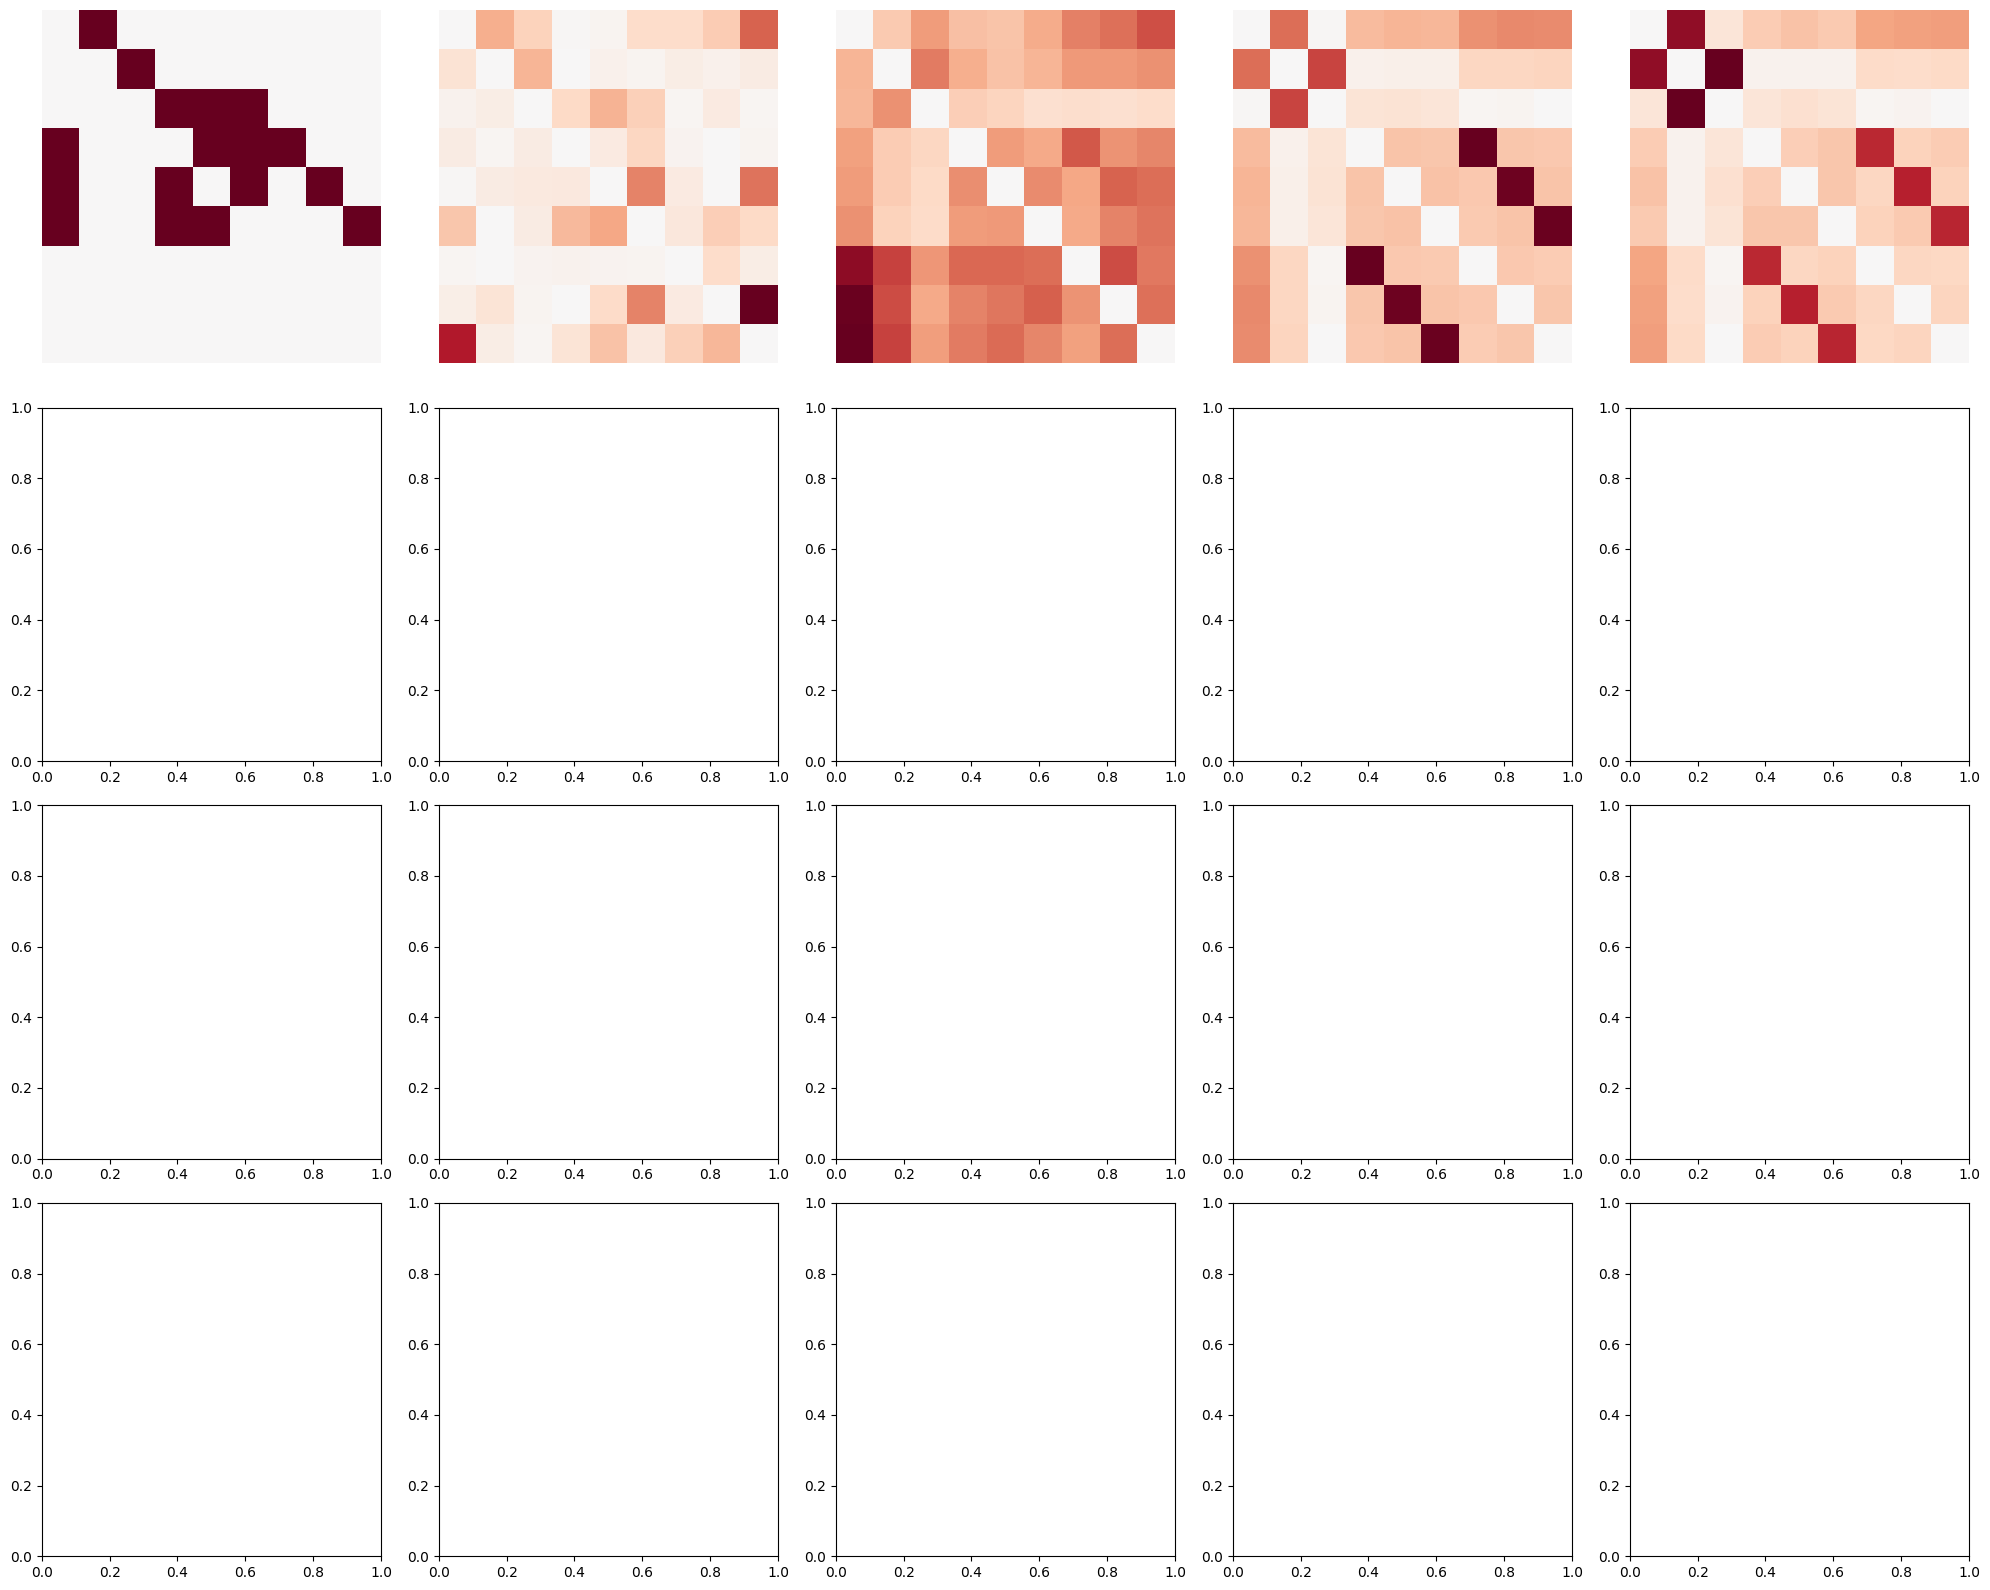

In [17]:
fig, axes = plt.subplots(4,5, figsize=(20,16))
#axes = axes.flatten()
#print(axes.shape, heatmaps.shape)
for i, h in enumerate(heatmaps):
    for j, p in enumerate(h):
        p = np.abs(p)* (1 - np.eye(p.shape[0]))
        sns.heatmap(p /p.max(), cmap="RdBu_r", center=0, cbar=False, 
                    xticklabels=False, yticklabels=False, ax = axes[i,j])
plt.tight_layout()